**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1188DQBNnxXgxxZoldO8cXiQFYaO9PoOh?usp=sharing)

2. Практический ноутбук 1

3. [Практический ноутбук 2](https://colab.research.google.com/drive/1pHONL5J4AVraE-SYJnpes7KdicPsD9qt?usp=sharing)

3. [Практический ноутбук 3](https://colab.research.google.com/drive/1tSOXY1AZ4-JrzlILL8bceAo2Syr3dJ2i?usp=sharing)


## Подключение бибилиотек


In [ ]:
# Основа для модели нейронной сети
from tensorflow.keras.models import Model 

# Стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization 

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# Дополнительные утилиты keras
from tensorflow.keras import utils 

# Инструменты для построения графиков
import matplotlib.pyplot as plt 

# Инструменты для работы с изображениями
from tensorflow.keras.preprocessing import image 

# Инструменты для работы с массивами
import numpy as np 

# Системные инструменты
import time, random, gdown, os

# Дополнительные инструменты для работы с изображениями
from PIL import Image 

# Дополнительные инструменты визуализации
import seaborn as sns
sns.set_style('darkgrid')

## Загрузка и обзор датасета

Загрузим базу "Стройка" для сегодняшнего занятия:

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

'construction_256x192.zip'

У вас на выбор есть база изображений в трех различных разрешениях:
- 1024х768
- 512х384
- 256х192

Вы можете скачать любую базу. В данном ноутбуке использованы изображения в разрешении **512х384**.


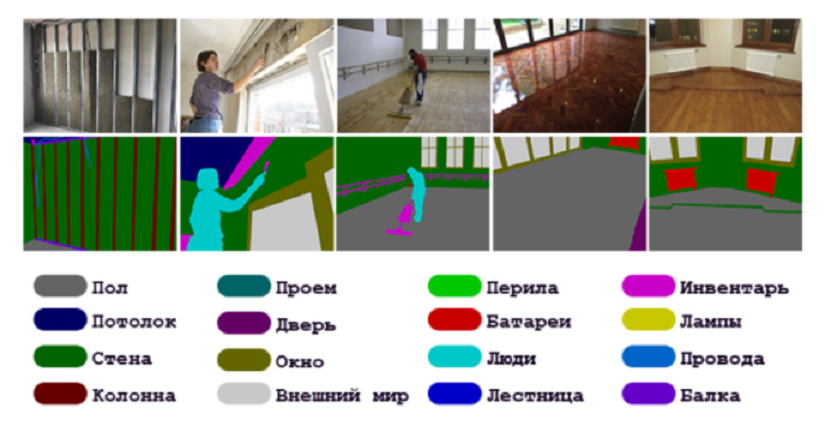

Задача состоит в составлении модели и обучении ее на наборе, состоящем из двух типов картинок:
- основное изображение;
- сегментированное изображение.

Обученная модель должна уметь находить различные классы на изображении и отмечать их разным цветом. Всего в базе содержатся объекты **16**-ти различных классов.

Распакуем архив:

In [ ]:
# Распаковка архива

!unzip -qo construction_256x192.zip

Зададим глобальные параметры:

In [ ]:
# Глобальные параметры

IMG_WIDTH = 192               # Ширина картинки 
IMG_HEIGHT = 256              # Высота картинки 
CLASS_COUNT = 16              # Количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

**CLASS_COUNT** - количество классов на изображениях. В первой части ноутбука мы попробуем создать модель, сегментирующую все **16** классов. Во второй части для снижения нагрузки на сеть попытаемся объединить различные мало представленные классы в один общий.

Первым делом подготовим списки, которые будут содержать изображения оригинальной и проверочной выборок. Для удобства и экономии кода создадим служебную функцию для загрузки списков.

In [ ]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')): 

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))               
        
    # Вывод времени загрузки картинок выборки    
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title, 
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list)) 

    return image_list

Определим также функцию для просмотра случайных изображений из набора:

In [ ]:
# Функция для просмотра изображений из набора

def show_imageset(image_list,  # выборка изображений
                  n            # количество картинок для просмотра
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))       # Создание полотна из n графиков

    # Вывод в цикле n случайных изображений
    for i in range(n): 
        img = random.choice(image_list)                   # Выборка случайного фото для отображения
        axs[i].axis('off')
        axs[i].imshow(img)                                # Отображение картинки

    plt.show()                                            # Отрисовка изображений

Загрузим входные изображения:

In [ ]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.25 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.02 с
Количество изображений: 100


Посмотрим случайные изображения из базы:

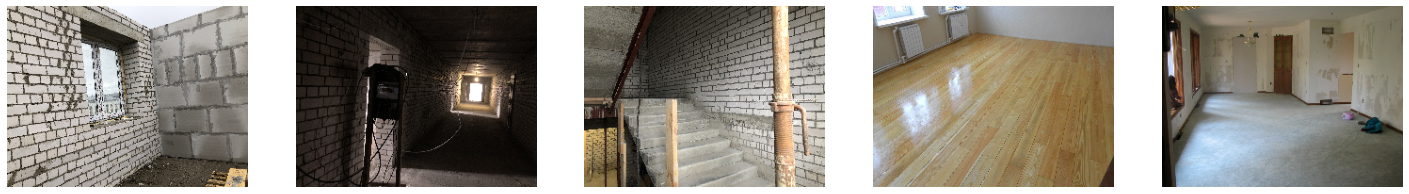

In [ ]:
# Просмотр входных изображений из обучающего набора

show_imageset(train_images, 5)

Загрузим сегментированные изображения:

In [ ]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.24 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.01 с
Количество изображений: 100


Посмотрим случайные сегментированные изображения из базы:

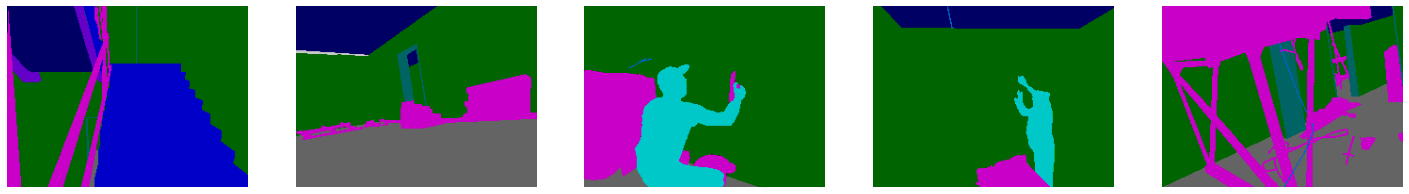

In [ ]:
# Просмотр сегментированных изображений из обучающего набора

show_imageset(train_segments, 5)

Зададим цвета пикселей каждого из **16**-ти классов:

In [ ]:
# Цвета пикселов сегментированных изображений

FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)

Объединим все в один список меток классов:

In [ ]:
CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

## Создание выборки

Мы определили, что на вход сегментирующей модели будут подаваться оригинальные цветные (трехканальные) изображения. А что же будет выходом модели? Что должен представлять из себя **y_train**?

В общем случае, на выходе модели мы должны получить тензор следующей формы: 

    ШИРИНА_ИЗОБРАЖЕНИЯ х ВЫСОТА_ИЗОБРАЖЕНИЯ х КОЛИЧЕСТВО_КЛАССОВ

Для нашей текущей модели, форма выходного тензора получается **384х512x16**. В данном случае последняя размерность (**16**) будет представлять собой класс пикселя в формате OHE. Например, если сеть решает, что пиксель относится к классу **потолок**, то в соотвутствующую позицию будет записан вектор:

    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Это довольно большой объем данных. Но мы можем немного "схитрить" и использовать очень удобный и мощный инструмент - фунукцию потерь **_"разреженная кроссэнтропия"_** `sparse_categorical_crossentropy()`, благодаря которой можно записать в **y_train** не вектор длины **16**, а просто одно число, соответствующее номеру класса. Это позволит заменить форму выходных данных с **384х512х16** на **384х512х1**, где в последнем измерении хранится номер класса.

Чтобы создать **y_train** по описанному выше принципу, выполним следующие шаги:
- открываем сегментированное изображение из базы;
- создаем выходной тензор формы **384х512х1**;
- для каждого пикселя сегментированного изображения определяем его класс (длячего и был выше создан кортеж **CLASS_LABELS**)
- записываем в выходной тензор на соответствующую позицию пикселя номер его класса.

Рассмотрим описанные шаги на примере одного изображения. Рассмотрим сегментированное изображение:

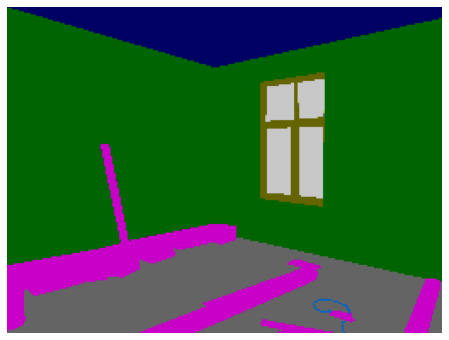

In [ ]:
sample = np.array(train_segments[10])
plt.figure(figsize=(10, 6))
plt.imshow(sample)
plt.axis('off')
plt.show()

Создадим нулевой выходной тензор:

In [ ]:
y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')

Заполним пикселы по цветам классов метками классов в выходном тензоре:

In [ ]:
for i, cl in enumerate(CLASS_LABELS):
    y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

Посмотрим на получившееся изображение:

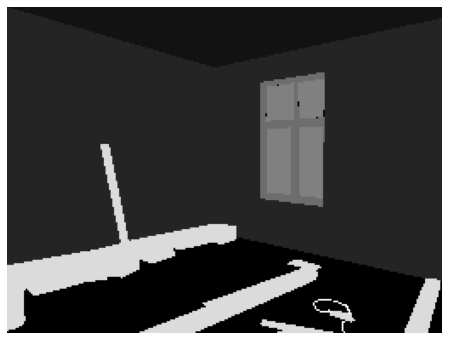

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(y[..., 0], cmap='gray')
plt.axis('off')
plt.show()

Мы получили ту же самую картинку, но в градациях серого, а объем выходного тензора стал в **16** (!) раз меньше.

Впоследствии нам понадобится две функции:
- перевод набора исходных сегментированых изображений в одноканальные изображения;
- перевод одноканальных изображений (результат работы модели) в цветные сегментированные изображения.

Напишем эти функции:

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений 
                 ):

    result = []
  
    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS): 
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i 

        result.append(y)
  
    return np.array(result)

In [ ]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений 
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)
  
    return np.array(result)

Проверим, как работает функция преобразования одноканального изображения в цветное на примере:

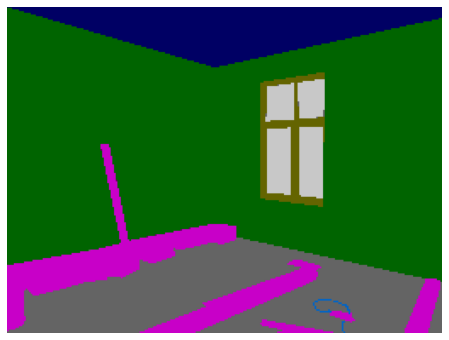

In [ ]:
orig = labels_to_rgb([y])
plt.figure(figsize=(10, 6))
plt.imshow(orig[0])
plt.axis('off')
plt.show()

Все сработало отлично.

А теперь сформируем выборки для обучения моделей сегментации:

In [ ]:
# Формирование обучающей выборки

x_train = []                          # Cписок под обучающую выборку

for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_train.append(x)                 # Добавление элемента в x_train

x_train = np.array(x_train)           # Перевод всей выборки в numpy
print(x_train.shape)                  # Форма x_train

(1900, 192, 256, 3)


In [ ]:
# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)                    # Форма x_train

(100, 192, 256, 3)


In [ ]:
# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(1900, 192, 256, 1)
(100, 192, 256, 1)


## Модель нейронной сети

Выборки готовы. Теперь можем приступать к проектированию моделей. Первым шагом попробуем создать простую линейную модель, принимающую на вход оригинальное цветное изображение и возвращающую одноканальное изображение того же размера:

In [ ]:
def sequential_segmentation_net(class_count,  # количество классов
                                input_shape   # форма входного изображения
                                ):

    img_input = Input(input_shape)                                              # Создаем входной слой формой input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)   

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv3')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                   # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv4')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)     

    x = Conv2D(16, (3, 3), padding='same', name='block1_conv5')(x)              # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                                 # Добавляем слой BatchNormalization
    x = Activation('relu')(x)           
       
    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)    # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                                 # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    # Возвращаем сформированную модель
    return model 

In [ ]:
# Создание модели и вывод сводки по архитектуре

model_seq = sequential_segmentation_net(CLASS_COUNT,
                                       (IMG_WIDTH, IMG_HEIGHT, 3))

model_seq.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 256, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 192, 256, 128)    512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 192, 256, 128)     0         
                                                                 
 block1_conv3 (Conv2D)       (None, 192, 256, 64)      73792     
                                                                 
 batch_normalization_1 (Batc  (None, 192, 256, 64)     256       
 hNormalization)                                             

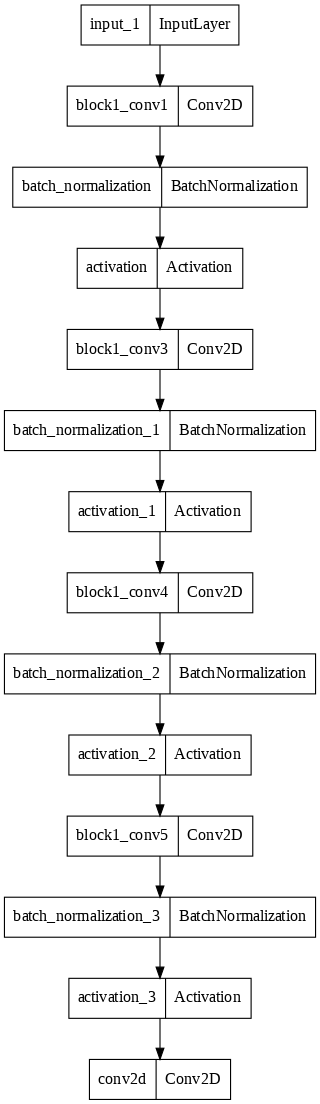

In [ ]:
# Вывод графической схемы архитектуры модели

utils.plot_model(model_seq, dpi=80)

In [ ]:
# Обучение модели

history = model_seq.fit(x_train, y_train,
                        epochs=50, batch_size=12,
                        validation_data=(x_val, y_val))

Epoch 1/50
159/159 [==============================] - 65s 297ms/step - loss: 1.5865 - sparse_categorical_accuracy: 0.5045 - val_loss: 2.3052 - val_sparse_categorical_accuracy: 0.3992
Epoch 2/50
159/159 [==============================] - 46s 289ms/step - loss: 1.4215 - sparse_categorical_accuracy: 0.5404 - val_loss: 2.8474 - val_sparse_categorical_accuracy: 0.1371
Epoch 3/50
159/159 [==============================] - 46s 289ms/step - loss: 1.3597 - sparse_categorical_accuracy: 0.5615 - val_loss: 2.2334 - val_sparse_categorical_accuracy: 0.2555
Epoch 4/50
159/159 [==============================] - 46s 288ms/step - loss: 1.3222 - sparse_categorical_accuracy: 0.5716 - val_loss: 1.9260 - val_sparse_categorical_accuracy: 0.4467
Epoch 5/50
159/159 [==============================] - 46s 289ms/step - loss: 1.2911 - sparse_categorical_accuracy: 0.5805 - val_loss: 2.0580 - val_sparse_categorical_accuracy: 0.3932
Epoch 6/50
159/159 [==============================] - 46s 289ms/step - loss: 1.2735 -

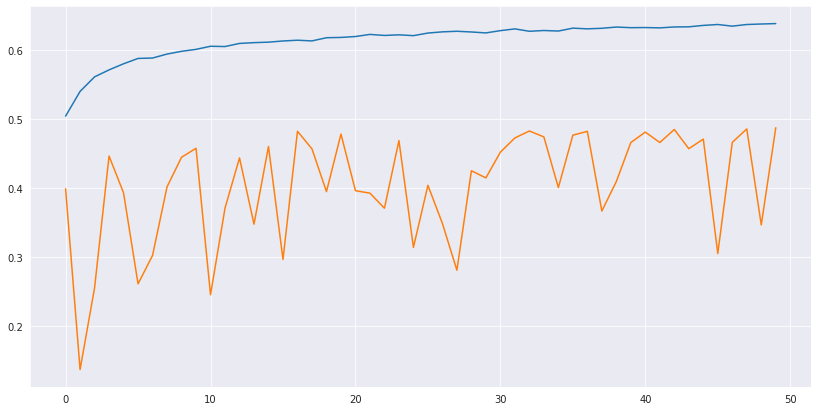

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

## Распознавание изображений

Определим функцию визуализации результатов работы модели:

In [ ]:
# Функция визуализации процесса сегментации изображений

def process_images(model,        # обученная модель
                   count = 1     # количество случайных картинок для сегментации
                   ):
  
    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
    indexes = np.random.randint(0, len(x_val), count)
    
    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 15)) 
    
    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show() 

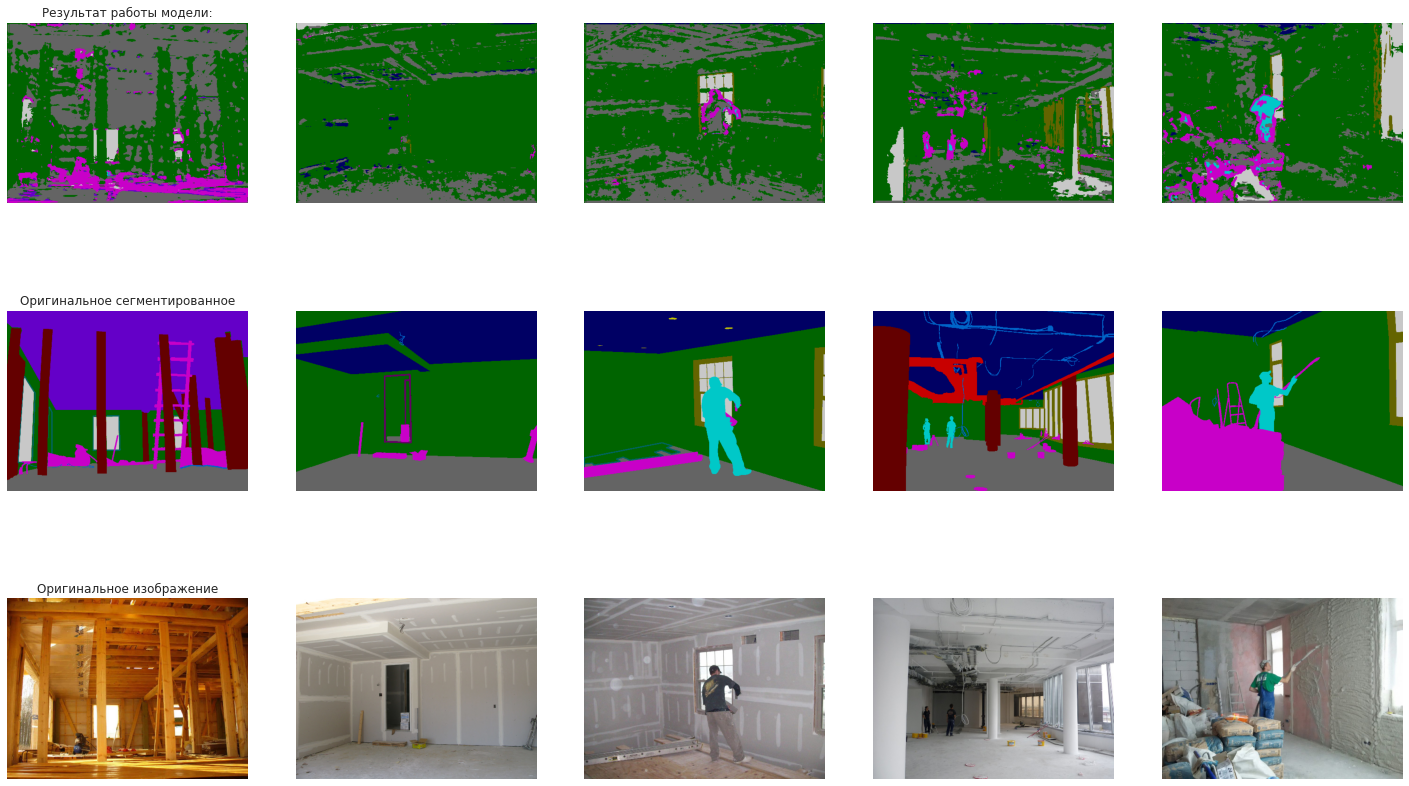

In [ ]:
# Отображение результатов работы модели

process_images(model_seq, 5)

**Выводы**

Можно сказать, что мы получили не самые плохие результаты. Где-то модель смогла обнаружить искомые объекты, где-то ошиблась. Но для первого эксперимента вполне достойно.

На следующем шаге мы уменьшим количество классов, объединив некоторые классы в один. Для этого посчитаем, сколько пикселей каждого класса есть в исходном датасете.

In [ ]:
# Вычисление количества пикселов по всем классам в y_train

pix_count = np.zeros(CLASS_COUNT)
for i in range(CLASS_COUNT):
    pix_count[i] = (y_train == i).sum()

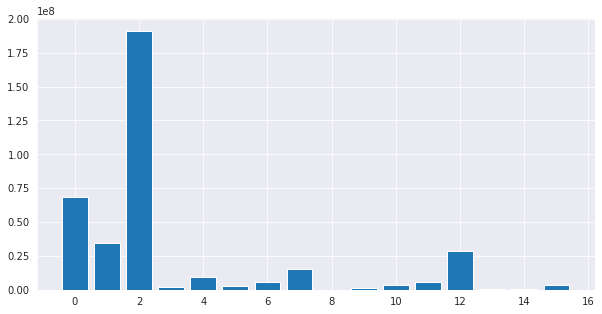

In [ ]:
# Отрисовка столбчатой диаграммы наполненности классов

plt.figure(figsize = (10, 5))
plt.bar(np.arange(CLASS_COUNT), pix_count)
plt.show()

Мы видим, что в нашей базе в большей степени присутствует класс **2**: **Стены**

Классы **Пол**, **Потолок** и **Инвентарь** представлены значительно меньше.

Остальных классов совсем мало. Попробуем создать модель для сегментации на **5** классов:
- Стены;
- Пол;
- Потолок;
- Инвентарь;
- Остальное.

Для этого слегка изменим **y_train** и **y_val**, объединив соответствующие классы.

In [ ]:
y_train5 = y_train.copy()
y_train5[(y_train5 > 2) & (y_train5 != 12)] = 3
y_train5[y_train5 == 12] = 4

In [ ]:
y_val5 = y_val.copy()
y_val5[(y_val5 > 2) & (y_val5 != 12)] = 3
y_val5[y_val5 == 12] = 4

Создадим, обучим и проверим новую модель той же архитектуре на исправленных данных:

In [ ]:
# Создание модели для уменьшенного набора классов

model_seq5 = sequential_segmentation_net(5,
                                        (IMG_WIDTH, IMG_HEIGHT, 3))
model_seq5.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 384, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 384, 512, 128)     3584      
_________________________________________________________________
batch_normalization_4 (Batch (None, 384, 512, 128)     512       
_________________________________________________________________
activation_4 (Activation)    (None, 384, 512, 128)     0         
_________________________________________________________________
block1_conv3 (Conv2D)        (None, 384, 512, 64)      73792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 384, 512, 64)      256       
_________________________________________________________________
activation_5 (Activation)    (None, 384, 512, 64)      0   

In [ ]:
# Обучение модели

history = model_seq5.fit(x_train, y_train5,
                         epochs=50, batch_size=12,
                         validation_data=(x_val, y_val5))

Epoch 1/50
159/159 [==============================] - 46s 287ms/step - loss: 1.2543 - sparse_categorical_accuracy: 0.5213 - val_loss: 1.6077 - val_sparse_categorical_accuracy: 0.2785
Epoch 2/50
159/159 [==============================] - 46s 286ms/step - loss: 1.1695 - sparse_categorical_accuracy: 0.5568 - val_loss: 1.7298 - val_sparse_categorical_accuracy: 0.2069
Epoch 3/50
159/159 [==============================] - 45s 285ms/step - loss: 1.1260 - sparse_categorical_accuracy: 0.5717 - val_loss: 1.8553 - val_sparse_categorical_accuracy: 0.1931
Epoch 4/50
159/159 [==============================] - 46s 287ms/step - loss: 1.0994 - sparse_categorical_accuracy: 0.5826 - val_loss: 1.5612 - val_sparse_categorical_accuracy: 0.3108
Epoch 5/50
159/159 [==============================] - 46s 287ms/step - loss: 1.0863 - sparse_categorical_accuracy: 0.5873 - val_loss: 1.6000 - val_sparse_categorical_accuracy: 0.2936
Epoch 6/50
159/159 [==============================] - 45s 286ms/step - loss: 1.0627 -

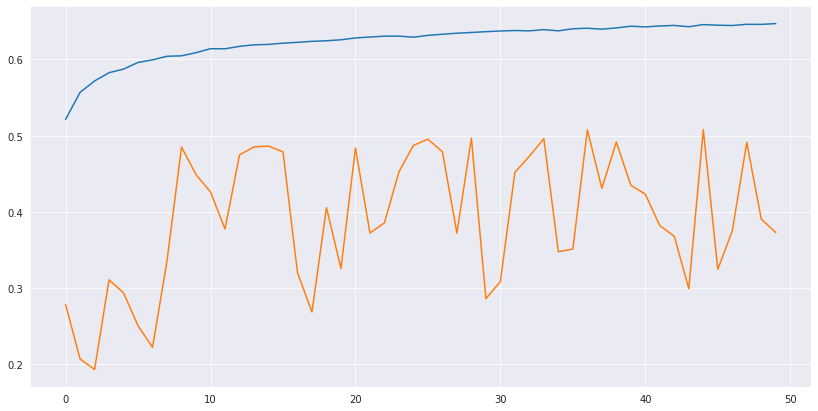

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

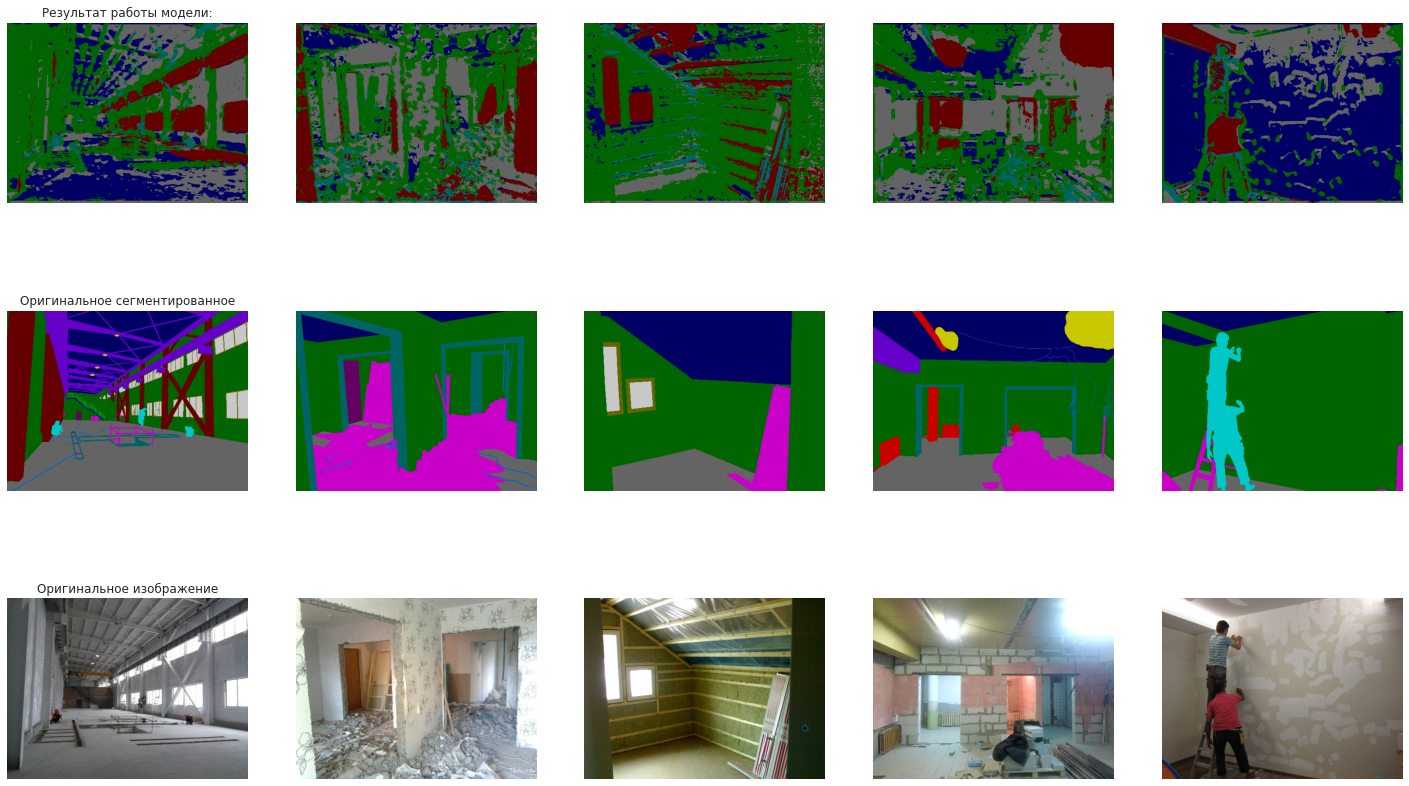

In [ ]:
# Отображение результатов работы модели

process_images(model_seq5, 5)

По численным значениям мы получаем чуть лучшие результаты, но в целом можно сказать, что у обеих моделей есть предел точности и они не могут "схватить" необходимые отличия классов. 

В следующей части урока будет разобрана архитектура **U-Net** и различные вариации на ее основе.

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1188DQBNnxXgxxZoldO8cXiQFYaO9PoOh?usp=sharing)

2. Практический ноутбук 1

3. [Практический ноутбук 2](https://colab.research.google.com/drive/1pHONL5J4AVraE-SYJnpes7KdicPsD9qt?usp=sharing)

3. [Практический ноутбук 3](https://colab.research.google.com/drive/1tSOXY1AZ4-JrzlILL8bceAo2Syr3dJ2i?usp=sharing)
